In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [3]:
from __future__ import division

import sys


import matplotlib.pyplot as plt
from nilearn import plotting
import numpy as np
import pandas as pd

import sklearn
from sklearn.cross_validation import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.svm import LinearSVR, LinearSVC

import entrainment_pred

In [4]:
full_atw = pd.read_csv("data/step3/full_atw.csv")
data_atw, target_atw = entrainment_pred.separate(full_atw, 'atw_z')
data_atw_df, target_atw_df = entrainment_pred.separate(full_atw, 'atw_diff_wpm')

full_adw = pd.read_csv("data/step3/full_adw.csv")
data_adw, target_adw = entrainment_pred.separate(full_adw, 'adw_z')

In [5]:
def log_dir_f(f_name):
    import os
    return os.path.join("data/step4/left_hemi/", f_name)

def load_logged_csv(f_name):
    return np.loadtxt(log_dir_f(f_name), delimiter=',')

### Create Best Pipelines

In [6]:
!cat {log_dir_f('search_results.log')} | grep "best params:"

INFO:atw_z:best params: {'svr__C': 1.1362635342572497e-05}
INFO:adw_z:best params: {'svr__C': 4.2787988344085613e-07}


In [7]:
!cat {log_dir_f('search_results.log')} | grep "norm"

INFO:atw_z:normalized: no
INFO:adw_z:normalized: no


In [8]:
def create_shuffle_split(target):
    return ShuffleSplit(len(target), 
                        n_iter=100, 
                        test_size=1/6.0, random_state=1234)


data_atw = data_atw.get_values()
svr_atw = LinearSVR(C=1.1362635342572497e-05)
pipe_atw = Pipeline([('svr', svr_atw)])
cv_atw = create_shuffle_split(target_atw)

data_adw = data_adw.get_values()
svr_adw = LinearSVR(C=4.2787988344085613e-07)
pipe_adw = Pipeline([('svr', svr_adw)])
cv_adw = create_shuffle_split(target_adw)

### Calculate Coefficients and Plot Closeness to Fit

In [9]:
def plot(predict_hist, target, title, sort=True, agg=np.mean, save=True):
    pmns = np.array([agg(predict_hist[i]) for i in predict_hist.keys()])
    
    plt_indices = np.argsort(target) if sort else x
    plt_indices = plt_indices[plt_indices.apply(lambda i: len(predict_hist[i]) > 0)]
    
    x = np.array(range(len(plt_indices)))
    
    pmns = pmns[plt_indices]
    target = target.get_values()[plt_indices]
    
    plt.scatter(x, pmns, c='y')
    
    p = plt.plot(x, target, marker='*')
    plt.title(title)
    plt.legend(["truth", "mean pred."], bbox_to_anchor=[.9, 1.0])
    msg = 'corr: %.2f' % np.corrcoef(
        pmns, target)[0][1]
    plt.text(.6, .95, msg, verticalalignment='top', fontsize=12, 
         horizontalalignment='right', transform=p[0].axes.transAxes)
    
    m, b = np.polyfit(x, pmns, 1)
    plt.plot(x, m*x + b, '-')
    
    if save:
        plt.savefig(title + '.jpg')

In [10]:
def calc_coeffs(best_estimator, cv, data, target, verbose=True):

    def _calc_coeffs(predicted_hist):
        n_iter = cv.n_iter
        if verbose: print('-' * n_iter)

        svr = best_estimator.named_steps['svr']
        def fit(train):
            best_estimator.fit(data[train], target[train])

        def predict(test):
            predicted = best_estimator.predict(data[test]).tolist()
            for i in test:
                predicted_hist[i].append(predicted.pop(0))

        def coeffs_fn():
            if verbose: sys.stdout.write('#')
            return svr.coef_.copy()

        coeffs = entrainment_pred.calc_coeffs(cv, fit, coeffs_fn, predict)
        return coeffs, predicted_hist
    
    return _calc_coeffs({i:[] for i in range(len(target))})
    

In [11]:
coeffs_adw, predict_hist_adw = calc_coeffs(pipe_adw, cv_adw, 
                                           data_adw, target_adw)
coeffs_atw, predict_hist_atw = calc_coeffs(pipe_atw, cv_atw, 
                                           data_atw, target_atw)

----------------------------------------------------------------------------------------------------
####################################################################################################----------------------------------------------------------------------------------------------------
####################################################################################################

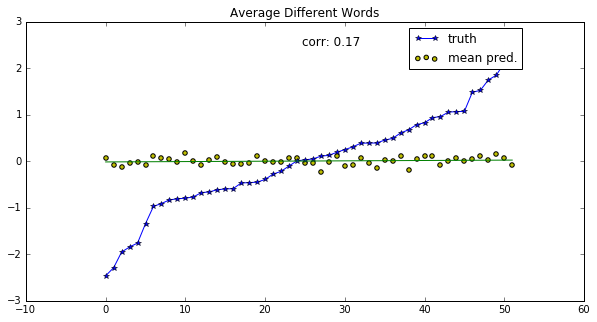

In [12]:
plot(predict_hist_adw, target_adw, 'Average Different Words')

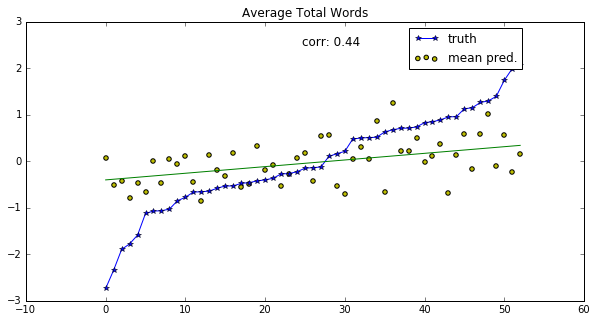

In [13]:
plot(predict_hist_atw, target_atw, 'Average Total Words')

### Plot Permutation Curve

In [14]:
!cat {log_dir_f("search_results.log")} | grep "best score:"

INFO:atw_z:best score: 0.360077495481
INFO:adw_z:best score: 0.336839287962


In [15]:
best_score_atw = 0.360077495481
best_score_adw = 0.336839287962

In [16]:
permute_pred_scores_atw = load_logged_csv('atw_z_permute_pred_scores.csv')
permute_pred_scores_adw = load_logged_csv('adw_z_permute_pred_scores.csv')

In [17]:
def plot_perm_scores(permute_scores, best_score, label):
    plt.hist(permute_scores, 20, label='Permutation scores ' + label);
    ylim = plt.ylim()
    plt.plot(2 * [best_score], ylim, '--g', linewidth=3,
             label='Classification Score')

    plt.ylim(ylim);
    plt.legend();
    plt.xlabel('Score');

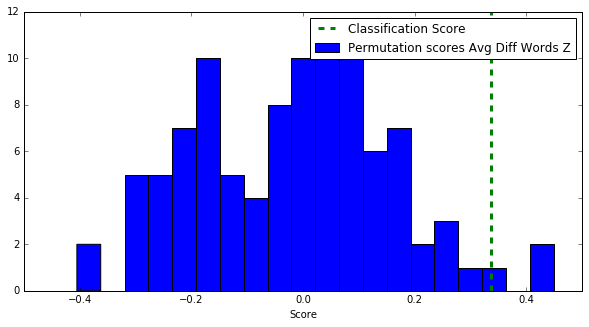

In [18]:
plot_perm_scores(permute_pred_scores_adw, best_score_adw, "Avg Diff Words Z")

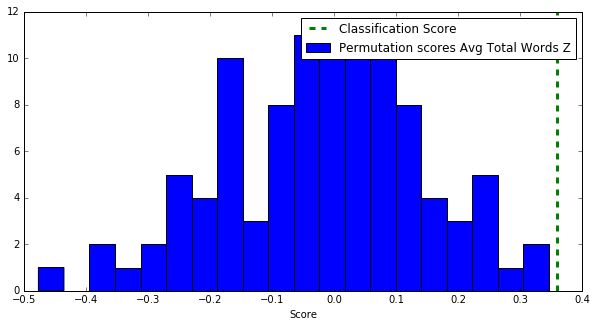

In [19]:
plot_perm_scores(permute_pred_scores_atw, best_score_atw, "Avg Total Words Z")

### Get Best Coefs

In [23]:
def load_csv(f_name):
    return load_logged_csv(f_name)

def valid_coefs(prefix, cutoff=.05):
    flat_coefs = load_csv(prefix + '_best_coefs.csv')
    perm_pos_coefs = np.sort(load_csv(prefix + '_permute_max_coefs.csv'))
    perm_neg_coefs = np.sort(load_csv(prefix + '_permute_min_coefs.csv'))
    
    valid_pos = flat_coefs.copy()
    valid_pos[valid_pos < 0] = 0
    
    valid_neg = flat_coefs.copy()
    valid_neg[valid_neg > 0] = 0
    
    if cutoff is not None:
        def within(val, max_val):
            if val < 0:
                return 0
            elif val > max_val:
                return max_val
            else:
                return val
        
        num_pos = len(perm_pos_coefs)
        pos_ix = int((1-cutoff/2) * num_pos)
        pos_ix = within(pos_ix + 1, num_pos - 1)
        pos_c = perm_pos_coefs[pos_ix]
        valid_pos[valid_pos < pos_c] = 0
        
        num_neg = len(perm_neg_coefs)
        neg_ix = int((cutoff/2) * num_neg)
        neg_ix = within(neg_ix - 1, num_neg - 1)
        neg_c = perm_neg_coefs[neg_ix]
        valid_neg[valid_neg > neg_c] = 0
    
    return flat_coefs, valid_pos, valid_neg, perm_pos_coefs, perm_neg_coefs

_, valid_pos_atw, valid_neg_atw, _, _ = valid_coefs('atw_z', cutoff=None)
_, valid_pos_adw, valid_neg_adw, _, _ = valid_coefs('adw_z', cutoff=None)


In [24]:
print (np.sum(valid_pos_atw), np.sum(valid_neg_atw))
print (np.sum(valid_pos_adw), np.sum(valid_neg_adw))

(0.18081159134319452, -0.17758279915350988)
(0.010827138217271368, -0.0066934507438968938)


In [25]:
def mk_coeffs_mat(coeffs):
    coeffs_mat = np.zeros((189, 189))
    ix = 0
    for i in range(189):
        for j in range(i+1, 189):
            coeffs_mat[i][j] = coeffs_mat[j][i] = coeffs[ix]
            ix += 1
    
    assert np.all(coeffs_mat == coeffs_mat.T)
    return coeffs_mat

In [26]:
atw_z = load_csv('atw_z_best_coefs.csv')

In [27]:
atw_z

array([-0.00021616, -0.00050868, -0.0036373 , ...,  0.00115162,
       -0.00018692,  0.00203217])

In [28]:
atw_z_mat = mk_coeffs_mat(atw_z)

IndexError: index 4465 is out of bounds for axis 0 with size 4465

In [29]:
atw_z

array([-0.00021616, -0.00050868, -0.0036373 , ...,  0.00115162,
       -0.00018692,  0.00203217])

In [30]:
sort(atw_z)

NameError: name 'sort' is not defined

In [32]:
!cat {log_dir_f("search_results.log")}

INFO:atw_z:results for atw_z
INFO:atw_z:normalized: yes
INFO:atw_z:best score: -0.0101360274636
INFO:atw_z:best params: {'svr__C': 0.098454657585896929}
INFO:atw_z:best score perms: -0.394349170977
INFO:atw_z:p-value: 0.0990099009901
INFO:adw_z:results for adw_z
INFO:adw_z:normalized: yes
INFO:adw_z:best score: 0.0107908601571
INFO:adw_z:best params: {'svr__C': 0.0062987888851660616}
INFO:adw_z:best score perms: -0.279855325332
INFO:adw_z:p-value: 0.0792079207921
